In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import math
import random
import matplotlib.pyplot as plt

# seed math and torch
torch.manual_seed(0)
random.seed(0)

# 3 vectors in x-z plane separated by 120 degrees
linear_feature_embeddings = torch.tensor([
    [0, 0, 1],
    [math.sin(math.pi/3), 0, math.cos(math.pi/3)],
    [-math.sin(math.pi/3), 0, math.cos(math.pi/3)],
]) 

num_linear_features = linear_feature_embeddings.shape[0]
expansion_factor = 2


angles = torch.arange(0, 2*math.pi, (2*math.pi/10)+1e-2)
x = torch.cos(angles)
y = torch.sin(angles)
# add random noise to the z axis of noise = sin(x)
# z = torch.sin(20*x) * 0.005
z = torch.zeros_like(x)
multi_dim_feature_embeddings = torch.cat([x.unsqueeze(1), y.unsqueeze(1), z.unsqueeze(1)], dim=1) 

multi_dim_feature_embeddings.shape

torch.Size([10, 3])

In [3]:
linear_feature_freqs = torch.tensor([1.0, 1.0, 1.0])
linear_feature_freqs /= linear_feature_freqs.sum(dim=0) 
multi_dim_feature_freqs = torch.ones(multi_dim_feature_embeddings.shape[0])
multi_dim_feature_freqs /= multi_dim_feature_freqs.sum(dim=0) 

linear_exists_prob = 0.4
multi_dim_exists_prob = 0.9

In [4]:
from utils.embeddings import sample_embeddings
dataset = [sample_embeddings(linear_feature_embeddings, multi_dim_feature_embeddings, linear_feature_freqs, multi_dim_feature_freqs, linear_exists_prob, multi_dim_exists_prob, dont_add_both=True) for _ in range(10000)]

# make a dataset out of it
labels = [d["label"] for d in dataset]
dataset = torch.stack([d["x"] for d in dataset])

In [5]:
from sae.sae_config import SAEConfig, MultiDimSAEConfig
from sae.sae import SAE
from sae.multi_dim_sae import MultiDimSAE
from torch.nn import functional as F

In [6]:
config = SAEConfig(input_dim=3, latent_dim=20, l1_weight=0.1, activation_fn=F.relu, learning_rate=0.001)
sae = SAE(config).train_model(dataset, num_epochs=1000)

100%|██████████| 1000/1000 [00:03<00:00, 331.97it/s]


In [7]:
sae.plot_losses()

In [8]:
concatenated_labels = torch.stack([torch.cat(label) for label in labels])

(concatenated_labels > 0).float().sum(dim=1).mean().item(), sae.logs["l0_norm"].to_numpy()[-1]

(1.3797999620437622, 3.7063000202178955)

In [9]:
m_config = SAEConfig(input_dim=3, latent_dim=num_linear_features*expansion_factor, l1_weight=0.1, activation_fn=F.relu, learning_rate=0.001, multi_dim_config=MultiDimSAEConfig(num_multi_dim_features=2))
m_sae = MultiDimSAE(m_config).train_model(dataset, num_epochs=2000)

100%|██████████| 2000/2000 [00:08<00:00, 222.49it/s]


In [10]:
m_sae.plot_losses()

In [11]:
m_sae.logs["l0_norm"].to_numpy()[-1], (concatenated_labels > 0).float().sum(dim=1).mean().item()

(1.8557000160217285, 1.3797999620437622)

In [12]:
sae_latents = m_sae.encode(dataset)

sae_latents[0].shape, sae_latents[1].shape

(torch.Size([10000, 6]), torch.Size([10000, 2]))

In [13]:
linear_labels = torch.arange(linear_feature_embeddings.shape[0])
multi_labels = torch.arange(multi_dim_feature_embeddings.shape[0])

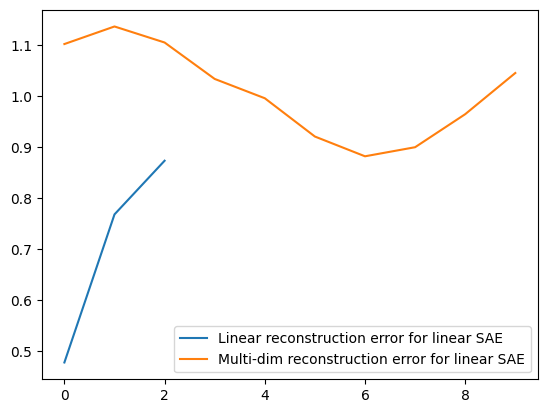

In [14]:
from utils.eval import compute_similarities
linear_similarities, multi_similarities = compute_similarities(m_sae, linear_feature_embeddings, multi_dim_feature_embeddings, use_linear_SAE=True)


plt.plot(linear_similarities, label="Linear reconstruction error for linear SAE")
plt.plot(multi_similarities, label="Multi-dim reconstruction error for linear SAE")
plt.legend()
plt.show()


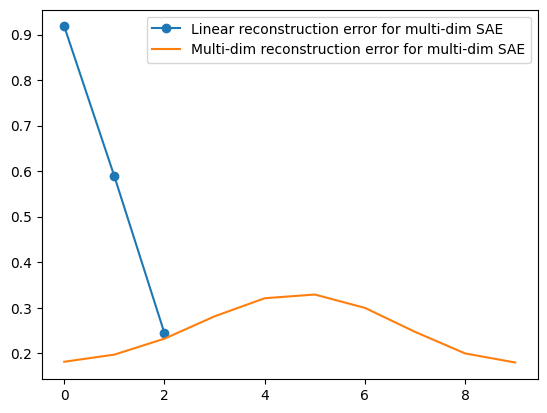

In [15]:
linear_similarities, multi_similarities = compute_similarities(m_sae, linear_feature_embeddings, multi_dim_feature_embeddings, use_linear_SAE=False)
plt.plot(linear_similarities, label="Linear reconstruction error for multi-dim SAE", marker="o")
plt.plot(multi_similarities, label="Multi-dim reconstruction error for multi-dim SAE")
plt.legend()
plt.show()

In [21]:
from utils.plotter import plot_latent_activations
plot_latent_activations(m_sae, linear_feature_embeddings, multi_dim_feature_embeddings, use_linear=True)
plot_latent_activations(m_sae, linear_feature_embeddings, multi_dim_feature_embeddings, use_linear=False)
